In [1]:
import sys
sys.path.append('C:\\Users\\MHJGuillermo\\PycharmProjects\\Doctorado\\Ising\\isingchat\\venv\\src')

In [2]:
%pylab inline

import h5py
import numpy as np
from isingchat.io import read_ising_config
from isingchat import ising
from matplotlib import pyplot, rcParams
from matplotlib.axes import Axes, GridSpec
from matplotlib.figure import Figure
from ruamel.yaml import YAML
from scipy import interpolate as interp
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
import pandas as pd
import json

import os
import re


Populating the interactive namespace from numpy and matplotlib


In [3]:
from isingchat.ising import _csr_log_transfer_matrix_parts_fast,csr_matrix,eigvals,_csr_finite_log_transfer_matrix_parts_fast
from scipy import linalg
temp = 3
mag_field = 0
interactions = np.array([1.0, 0.5,0.25])
num_neighbors = 3

nnz_elems, nnz_rows, nnz_cols = _csr_log_transfer_matrix_parts_fast(
    temp, mag_field, interactions, num_neighbors
)

# Normalize nonzero matrix elements.
max_w_log_elem = np.max(nnz_elems)
nnz_elems -= max_w_log_elem
norm_nnz_elems = np.exp(nnz_elems)
# Construct the sparse matrix.
num_rows = 2 ** num_neighbors
w_shape = (num_rows, num_rows)
w_matrix = csr_matrix(
    (norm_nnz_elems, (nnz_rows, nnz_cols)), shape=w_shape
)
# Strictly, we should calculate all the eigenvalues and calculate the
# Free energy according to F. A, Kassan-ogly (2001),
#   https://www.tandfonline.com/doi/abs/10.1080/0141159010822758.
eigenval, eigenvect = linalg.eig(w_matrix.todense())
print("eigenvals: {}\neigenvect: {}".format(eigenval,eigenvect))


eigenvals: [ 1.24263681+0.j          0.9073365 +0.j         -0.21486628+0.30057257j
 -0.21486628-0.30057257j  0.34436658+0.j         -0.07620259+0.14002203j
 -0.07620259-0.14002203j  0.08779787+0.j        ]
eigenvect: [[ 0.6349682 +0.00000000e+00j  0.66984521+0.00000000e+00j
  -0.32195334-7.96551384e-02j -0.32195334+7.96551384e-02j
  -0.52747865+0.00000000e+00j -0.32034058-4.16787121e-02j
  -0.32034058+4.16787121e-02j -0.35330694+0.00000000e+00j]
 [ 0.18200825+0.00000000e+00j -0.07332728+0.00000000e+00j
   0.49035011+0.00000000e+00j  0.49035011-0.00000000e+00j
   0.40855298+0.00000000e+00j  0.41416995+2.88657986e-15j
   0.41416995-2.88657986e-15j  0.38073751+0.00000000e+00j]
 [ 0.13534078+0.00000000e+00j  0.07658179+0.00000000e+00j
  -0.30003658+8.93917416e-02j -0.30003658-8.93917416e-02j
   0.2306671 +0.00000000e+00j  0.15002194+2.93362693e-01j
   0.15002194-2.93362693e-01j  0.33631997+0.00000000e+00j]
 [ 0.21300531+0.00000000e+00j -0.20016428+0.00000000e+00j
   0.18074255+1.37394225e

In [4]:
# order_eig = np.array([eigenvect[:,3],eigenvect[:,5],
#                        eigenvect[:,2],eigenvect[:,4],
#                       eigenvect[:,1],eigenvect[:,6],
#                       eigenvect[:,0],eigenvect[:,7],
#                     ])
order_eig = np.array([eigenvect[3],eigenvect[5],
                       eigenvect[2],eigenvect[4],
                      eigenvect[1],eigenvect[6],
                      eigenvect[0],eigenvect[7],
                    ])
# order_eig_val = np.array([eigenval[3],eigenval[5],
#                        eigenval[2],eigenval[4],
#                       eigenval[1],eigenval[6],
#                       eigenval[0],eigenval[7],
#                     ])
# # order_eig = np.array([eigenvect[1],eigenvect[2],
# #                       eigenvect[0],eigenvect[3]])
print(order_eig)
# print(order_eig_val)

[[ 0.21300531+0.00000000e+00j -0.20016428+0.00000000e+00j
   0.18074255+1.37394225e-01j  0.18074255-1.37394225e-01j
  -0.0405391 +0.00000000e+00j -0.22926498-2.50952915e-01j
  -0.22926498+2.50952915e-01j -0.34220174+0.00000000e+00j]
 [ 0.13534078+0.00000000e+00j -0.07658179+0.00000000e+00j
   0.30003658-8.93917416e-02j  0.30003658+8.93917416e-02j
   0.2306671 +0.00000000e+00j  0.15002194+2.93362693e-01j
   0.15002194-2.93362693e-01j -0.33631997+0.00000000e+00j]
 [ 0.13534078+0.00000000e+00j  0.07658179+0.00000000e+00j
  -0.30003658+8.93917416e-02j -0.30003658-8.93917416e-02j
   0.2306671 +0.00000000e+00j  0.15002194+2.93362693e-01j
   0.15002194-2.93362693e-01j  0.33631997+0.00000000e+00j]
 [ 0.21300531+0.00000000e+00j  0.20016428+0.00000000e+00j
  -0.18074255-1.37394225e-01j -0.18074255+1.37394225e-01j
  -0.0405391 +0.00000000e+00j -0.22926498-2.50952915e-01j
  -0.22926498+2.50952915e-01j  0.34220174+0.00000000e+00j]
 [ 0.18200825+0.00000000e+00j -0.07332728+0.00000000e+00j
   0.49035

In [5]:
from isingchat.ising import z_projection_gen
sigma_z = z_projection_gen(2)
print("sigma_gen: {}".format(sigma_z.todense()))

# unitary_mat = np.matrix.transpose(eigenvect)
# unitary_mat = order_eig
unitary_mat = eigenvect
inverse_unitary_mat = linalg.inv(unitary_mat)
np.dot(np.dot(inverse_unitary_mat,w_matrix.todense()),unitary_mat)
np.dot(np.dot(inverse_unitary_mat,sigma_z.todense()),unitary_mat)

sigma_gen: [[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. -1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0. -1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0. -1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0. -1.]]


matrix([[ 6.95088653e-16-3.31891497e-17j,
          4.72844666e-01-1.87482868e-18j,
          2.17412463e-02+9.26111617e-02j,
          2.17412463e-02-9.26111617e-02j,
          1.48116646e-16-1.19762313e-17j,
          4.33017767e-16+2.85718615e-16j,
          4.32897086e-16-2.93585059e-16j,
         -7.50918720e-04-4.25799309e-18j],
        [ 1.54964667e+00-8.92662178e-17j,
         -1.19154153e-15-9.14780989e-18j,
         -6.34573672e-16+3.74932634e-16j,
         -6.36740858e-16-2.58791964e-16j,
         -1.84329523e-01-2.08408706e-17j,
          2.21392279e-02+1.86379832e-02j,
          2.21392279e-02-1.86379832e-02j,
         -3.40792583e-16+3.48547508e-17j],
        [ 3.33077352e-01-1.36438007e+00j,
         -7.88136835e-16+6.35238464e-16j,
          2.59179562e-15-1.22043914e-15j,
          3.09115849e-15-4.15527447e-16j,
          1.25181274e-01-4.44077312e-01j,
          1.39839259e-01-1.12010954e-01j,
          1.37801551e-01+2.84270129e-01j,
         -1.49149894e-15+1.37237

In [8]:
eigenval.sort()
eigenval

array([-0.21486628-0.30057257j, -0.21486628+0.30057257j,
       -0.07620259-0.14002203j, -0.07620259+0.14002203j,
        0.08779787+0.j        ,  0.34436658+0.j        ,
        0.9073365 +0.j        ,  1.24263681+0.j        ])

In [9]:
def correlation_function(r):
    return (eigenval[0]/eigenval[-1])**r

C:\Users\MHJGuillermo\PycharmProjects\Doctorado\Ising\isingchat\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


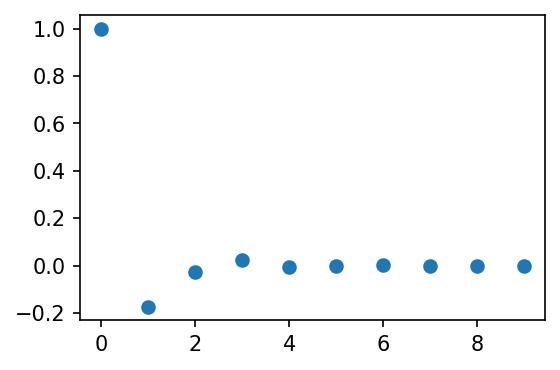

In [13]:
# Load the default style.
style.use("default")
rcParams["text.usetex"] = False

fig1: Figure = pyplot.figure(figsize=(4, 9), dpi=150)
grid_spec = GridSpec(3, 1)

# Specific heat subplot.
ax: Axes = fig1.add_subplot(grid_spec[0, 0])

x_data = np.arange(0,10,1)
y_data = correlation_function(x_data)
ax.plot(x_data, y_data, marker="o", lw=0,color='C0',label='adjust without nv=1')